In [202]:
# import other files
%run validation.ipynb

# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping


In [159]:
random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)

In [160]:
# import data from "nba_data_collection" stage
all_nba_df = pd.read_csv('./data/all_stats_2000_23.csv')

# clean up the unuseful columns
all_nba_df = all_nba_df.drop(['NICKNAME', 'TEAM_ID', 'NBA_FANTASY_PTS', 'WNBA_FANTASY_PTS', 'NBA_FANTASY_PTS_RANK', 'WNBA_FANTASY_PTS_RANK'], axis=1)

# we are trying to predict the NBA 2022-23 MVP, so isolate this season out
nba_2023 = pd.read_csv('./data/all_stats_2000_23.csv')
nba_2023 = nba_2023[(nba_2023['season_id']== '2022-23')].reset_index(drop=True)
# import team stats to get Game Played stats
team_stats_2022_23_df = pd.read_csv('./data/team_stats_2022_23.csv')
team_stats_2022_23_df = team_stats_2022_23_df[['TEAM_ID', 'GP']]
team_stats_2022_23_df = team_stats_2022_23_df.rename({'GP': 'team_GP'}, axis=1)

nba_2023 = pd.merge(nba_2023, team_stats_2022_23_df, left_on = ['TEAM_ID'], right_on = ['TEAM_ID'], how = 'left')
nba_2023['GP_PCT'] = nba_2023['GP']/nba_2023['team_GP']
nba_2023 = nba_2023.drop(['NICKNAME', 'TEAM_ID', 'GP','NBA_FANTASY_PTS', 'WNBA_FANTASY_PTS', 'NBA_FANTASY_PTS_RANK', 'WNBA_FANTASY_PTS_RANK', 'team_GP'], axis=1)

In [161]:
past_mvps = pd.read_csv('./data/past_mvps_2000_22.csv')
past_mvps = past_mvps[['Player', 'season_id', 'Share']]

# left join all nba stats and mvp results
nba_2000_22 = all_nba_df[(all_nba_df['season_id']!= '2022-23')].reset_index(drop=True)
nba_2000_22 = pd.merge(nba_2000_22, past_mvps, left_on = ['PLAYER_NAME', 'season_id'], right_on = ['Player', 'season_id'], how = 'left')
nba_2000_22['GP_PCT'] = nba_2000_22['GP']/82
nba_2000_22 = nba_2000_22.drop(['Player', 'GP'], axis=1)
nba_2000_22['Share'] = nba_2000_22['Share'].fillna(0.000)

In [162]:
# since there are approx. 450 players in the NBA per season, but not all are qualified for MVP selection. We use past MVP's lowest stats to filter players out
# the stats we are using are the ones that show the impact of players on their teams
# Filter:
# winning percentage: lowest winning percentage on MVP's team in the past is 45.3%
# minutes per game: lowest minutes per game for a MVP is 30.4 min
# GP: lowest game played for an MVP per season is 49 per game
# +/-: lowest +/- for an MVP is 3.1
# offensive rating: lowest offensive rating is 104.7
# defensive rating: highest defensive rating is 110.6
# since we might mis-filter past MVPs out so if they had MVP shares, we still keep the players
# &(nba_2000_22['OFF_RATING'] >= 104.7)&(nba_2000_22['DEF_RATING'] <= 110.6)
filtered_nba_2000_22 = nba_2000_22[((nba_2000_22['W_PCT'] >= 0.453)&
                                    (nba_2000_22['MIN'] >= 30.4)&
                                    (nba_2000_22['GP_PCT'] >= 0.5976)&
                                    (nba_2000_22['PLUS_MINUS'] >= 3.1)&
                                    (nba_2000_22['OFF_RATING'] >= 104.7)&
                                    (nba_2000_22['DEF_RATING'] <= 110.6))|(nba_2000_22['Share']>0)].reset_index(drop=True)
nba_2023 = nba_2023[((nba_2023['W_PCT'] >= 0.453)&
                     (nba_2023['MIN'] >= 30.4)&
                     (nba_2023['GP_PCT'] >= 0.5976)&
                     (nba_2023['PLUS_MINUS'] >= 3.1))].reset_index(drop=True)
nba_2023_model = nba_2023.drop(['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ABBREVIATION', 'season_id'], axis = 1)

In [163]:
# split training and testing data set 
# training: 2000-2018, testing: 2019-2022, predict: 2023
# training
nba_2000_18 = filtered_nba_2000_22.loc[(filtered_nba_2000_22['season_id'] != '2019-20') 
                         & (filtered_nba_2000_22['season_id'] != '2020-21')
                         & (filtered_nba_2000_22['season_id'] != '2021-22')]

share_2000_18 = nba_2000_18[['Share']].values.ravel()
nba_2000_18_model = nba_2000_18.drop(['Share', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ABBREVIATION', 'season_id'], axis = 1)

# testing
nba_2019_22 = filtered_nba_2000_22.loc[(filtered_nba_2000_22['season_id'] == '2019-20') 
                         | (filtered_nba_2000_22['season_id'] == '2020-21')
                         | (filtered_nba_2000_22['season_id'] == '2021-22')]
share_2019_22 = nba_2019_22[['Share']].values.ravel()
nba_2019_22_model = nba_2019_22.drop(['Share', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ABBREVIATION', 'season_id'], axis = 1)

In [164]:
# Assuming that X and y are already defined and X is a pandas DataFrame
# StandardScaler
scaler = StandardScaler()
scaler.fit(nba_2000_18_model)
nba_2000_18_scaled = scaler.transform(nba_2000_18_model)
nba_2019_22_scaled = scaler.transform(nba_2019_22_model)
nba_2023_scaled = scaler.transform(nba_2023_model)

# SelectKBest
k = 20 # number of top features to select
selector = SelectKBest(f_regression, k=k)
selector.fit(nba_2000_18_scaled, share_2000_18)
nba_2000_18_new = selector.transform(nba_2000_18_scaled)
nba_2019_22_new = selector.transform(nba_2019_22_scaled)
nba_2023_new = selector.transform(nba_2023_scaled)

# Get the p-values and F-scores of the selected features
p_values = selector.pvalues_
f_scores = selector.scores_
selected_features = nba_2000_18_model.columns[selector.get_support()]

# Print the selected feature names, F-scores and p-values
# for feature, f_score, p_value in zip(selected_features, f_scores, p_values):
#    print(f"Feature: {feature}, F-score: {f_score:.2f}, p-value: {p_value:.2g}")

In [165]:
selected_features

Index(['FGM', 'FGA', 'FTM', 'FTA', 'TOV', 'PTS', 'DD2', 'FGM_RANK', 'TOV_RANK',
       'PTS_RANK', 'AST_PCT', 'USG_PCT', 'E_USG_PCT', 'PIE', 'FGM_PG',
       'FGA_PG', 'USG_PCT_RANK', 'E_USG_PCT_RANK', 'FGM_PG_RANK',
       'FGA_PG_RANK'],
      dtype='object')

In [168]:
# create an empty dictionary to store the prediction results
test_values = {}
trained_models = {}

In [169]:
# Support Vector Regression 
param_grid = {'C': [0.001,0.01,0.1,0.5,1,2,5,10],
             'kernel': ['linear','rbf','poly'],
             'gamma': ['scale','auto'],
             'degree': [2,3,4],
             'epsilon': [0.1,0.5,1]}
model_svr = SVR()
kf = KFold(n_splits=10, shuffle=True, random_state=1)
grid = GridSearchCV(model_svr, param_grid, cv = kf)
grid.fit(nba_2000_18_new, share_2000_18)

# train SVR
model_svr.fit(nba_2000_18_new, share_2000_18)
trained_models['SVR'] = model_svr

# get test set values
y_pred_svr = model_svr.predict(nba_2019_22_new)
y_pred_svr = np.clip(y_pred_svr, 0, 1)
test_values['SVR'] = y_pred_svr

# test result
svr_metrics = pd.DataFrame()
svr_metrics = testing_metrics(share_2019_22, y_pred_svr, svr_metrics, 'SVR', '2019_22')
svr_metrics

,Season,Model,RMSE,R_Square
0,2019_22,SVR,0.141,0.629


In [170]:
# Gradient Boosting
param_grid = {'n_estimators': [10,20,30,40,50],
                             'learning_rate': [0.01,0.05,0.1,0.2,0.5],
                             'max_depth': [3,4,5]}
gb_model = GradientBoostingRegressor()
kf = KFold(n_splits=10, shuffle=True, random_state=1)
grid = GridSearchCV(gb_model, param_grid, cv = kf)
grid.fit(nba_2000_18_new, share_2000_18)
model_gb = GradientBoostingRegressor(**grid.best_params_)


# train Gradient Boosting
model_gb.fit(nba_2000_18_new, share_2000_18)
trained_models['Gradient Boosting'] = model_gb

# get test set values
y_pred_gb = model_gb.predict(nba_2019_22_new)
test_values['Gradient Boosting'] = y_pred_gb

# test result
gb_metrics = pd.DataFrame()
gb_metrics = testing_metrics(share_2019_22, y_pred_gb, gb_metrics, 'Gradient Boosting', '2019_22')
gb_metrics

,Season,Model,RMSE,R_Square
0,2019_22,Gradient Boosting,0.106,0.789


In [171]:
# Random Forest
param_grid = {'n_estimators': [100, 150, 200, 250],
                             'max_features': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                             'bootstrap': [True,False],
                             'oob_score': [True,False]}
rfc = RandomForestRegressor()
kf = KFold(n_splits=10, shuffle=True, random_state=1)
grid = GridSearchCV(rfc, param_grid, cv = kf)
grid.fit(nba_2000_18_new, share_2000_18)
model_rf = RandomForestRegressor(**grid.best_params_)


model_rf.fit(nba_2000_18_new, share_2000_18)
trained_models['Random Forest'] = model_rf

# get test set values
y_pred_rf = model_rf.predict(nba_2019_22_new)
test_values['Random Forest'] = y_pred_rf

# test result
rf_metrics = pd.DataFrame()
rf_metrics = testing_metrics(share_2019_22, y_pred_rf, rf_metrics, 'Random Forest', '2019_22')
rf_metrics


400 fits failed out of a total of 1600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
400 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/frankhung/opt/anaconda3/envs/nba/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/frankhung/opt/anaconda3/envs/nba/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 434, in fit
    raise ValueError("Out of bag estimation only available if bootstrap=True")
ValueError: Out of bag estimation only available if bootstrap=True

One or more of the test scores are non-finite: [ 0.31146053  0.29347549  0.31597997  0.31631474  0.31792569  0.32476

,Season,Model,RMSE,R_Square
0,2019_22,Random Forest,0.125,0.708


In [222]:
# NN
# Define the neural network architecture
df_shape = nba_2000_18_new.shape[1]

# layers of NN
np.random.seed(123)
tf.random.set_seed(123)
model_nn = keras.models.Sequential([keras.layers.Dense(8, activation='relu', input_shape=(df_shape,), kernel_regularizer=regularizers.l2(0.01))])
model_nn.add(layers.Dense(1, activation='relu'))

# Compile the model
model_nn.compile(optimizer='adam', loss='MSLE')

# Train the model
early_stopping = EarlyStopping(monitor='loss', patience=3)
model_nn.fit(nba_2000_18_new, share_2000_18, epochs=200, batch_size=10, callbacks=[early_stopping])
trained_models['Neural Network'] = model_nn

# get test set values
y_pred_nn = model_nn.predict(nba_2019_22_new)
y_pred_nn = y_pred_nn.reshape((nba_2019_22_new.shape[0],))
test_values['Neural Network'] = y_pred_nn

# test result
nn_metrics = pd.DataFrame()
nn_metrics = testing_metrics(share_2019_22, y_pred_nn, nn_metrics, 'Neural Network', '2019_22')
nn_metrics

Epoch 1/200
57/57 [==============================] - 0s 604us/step - loss: 0.2476
Epoch 2/200
57/57 [==============================] - 0s 534us/step - loss: 0.1380
Epoch 3/200
57/57 [==============================] - 0s 537us/step - loss: 0.1209
Epoch 4/200
57/57 [==============================] - 0s 535us/step - loss: 0.1069
Epoch 5/200
57/57 [==============================] - 0s 533us/step - loss: 0.0957
Epoch 6/200
57/57 [==============================] - 0s 544us/step - loss: 0.0865
Epoch 7/200
57/57 [==============================] - 0s 523us/step - loss: 0.0788
Epoch 8/200
57/57 [==============================] - 0s 536us/step - loss: 0.0727
Epoch 9/200
57/57 [==============================] - 0s 523us/step - loss: 0.0676
Epoch 10/200
57/57 [==============================] - 0s 551us/step - loss: 0.0627
Epoch 11/200
57/57 [==============================] - 0s 526us/step - loss: 0.0580
Epoch 12/200
57/57 [==============================] - 0s 532us/step - loss: 0.0542
Epoch 13/200


,Season,Model,RMSE,R_Square
0,2019_22,Neural Network,0.138,0.647


In [226]:
metrics = pd.DataFrame()
for key, value in test_values.items():
    metrics = testing_metrics(share_2019_22, value, metrics, key, '2019_22')
metrics

,Season,Model,RMSE,R_Square
0,2019_22,SVR,0.141,0.629
1,2019_22,Gradient Boosting,0.106,0.789
2,2019_22,Random Forest,0.125,0.708
3,2019_22,Neural Network,0.138,0.647


In [227]:
# nba 2023 MVP prediction
results = nba_2023[['PLAYER_NAME', 'TEAM_ABBREVIATION', 'season_id']]
mvp_prediction = {}
for key, model in trained_models.items():
    predicted = model.predict(nba_2023_new)
    predicted = predicted.reshape((nba_2023_new.shape[0],))
    

    results['Predicted MVP Share'] = pd.Series(predicted).values
    results = results.loc[(results['season_id'] == '2022-23')]
    # get top 10 results
    results_sorted = results.sort_values(by='Predicted MVP Share',
                                                ascending=False).reset_index(drop=True)
    mvp_prediction[key] = results_sorted[0:3]

1/1 [==============================] - 0s 43ms/step



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [228]:
mvp_prediction

{'SVR':              PLAYER_NAME TEAM_ABBREVIATION season_id  Predicted MVP Share
 0            Joel Embiid               PHI   2022-23             0.729379
 1  Giannis Antetokounmpo               MIL   2022-23             0.647504
 2           Nikola Jokic               DEN   2022-23             0.518084,
 'Gradient Boosting':              PLAYER_NAME TEAM_ABBREVIATION season_id  Predicted MVP Share
 0            Joel Embiid               PHI   2022-23             0.657762
 1  Giannis Antetokounmpo               MIL   2022-23             0.546637
 2           LeBron James               LAL   2022-23             0.293796,
 'Random Forest':              PLAYER_NAME TEAM_ABBREVIATION season_id  Predicted MVP Share
 0            Joel Embiid               PHI   2022-23             0.721960
 1  Giannis Antetokounmpo               MIL   2022-23             0.554787
 2           Nikola Jokic               DEN   2022-23             0.459720,
 'Neural Network':              PLAYER_NAME TEAM_ABB

In [229]:
# nba 2019 to 2022 MVP prediction
results = nba_2019_22[['PLAYER_NAME', 'TEAM_ABBREVIATION', 'season_id']]
test_season_list = ['2019-20', '2020-21', '2021-22']
model_past_mvp = {}
for key, model in trained_models.items():
    predicted = model.predict(nba_2019_22_new)
    predicted = np.clip(predicted, 0, 1)
    predicted = predicted.reshape((nba_2019_22_new.shape[0],))
    
    results['Predicted MVP Share'] = pd.Series(predicted).values
    past_mvp = {}
    for season in test_season_list:
        season_results = results.loc[(results['season_id'] == season)]
        season_results_sorted = season_results.sort_values(by='Predicted MVP Share',
                                                ascending=False).reset_index(drop=True)
        past_mvp[season] = season_results_sorted[0:3]
    
    model_past_mvp[key]  = past_mvp


3/3 [==============================] - 0s 943us/step



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [230]:
model_past_mvp

{'SVR': {'2019-20':              PLAYER_NAME TEAM_ABBREVIATION season_id  Predicted MVP Share
  0  Giannis Antetokounmpo               MIL   2019-20             1.000000
  1           James Harden               HOU   2019-20             0.539364
  2           LeBron James               LAL   2019-20             0.502902,
  '2020-21':              PLAYER_NAME TEAM_ABBREVIATION season_id  Predicted MVP Share
  0           Nikola Jokic               DEN   2020-21             0.639179
  1          Stephen Curry               GSW   2020-21             0.563400
  2  Giannis Antetokounmpo               MIL   2020-21             0.555905,
  '2021-22':              PLAYER_NAME TEAM_ABBREVIATION season_id  Predicted MVP Share
  0           Nikola Jokic               DEN   2021-22             0.955808
  1  Giannis Antetokounmpo               MIL   2021-22             0.695438
  2            Joel Embiid               PHI   2021-22             0.612226},
 'Gradient Boosting': {'2019-20':           

Using 566 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 78/78 [37:44<00:00, 29.04s/it] 
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


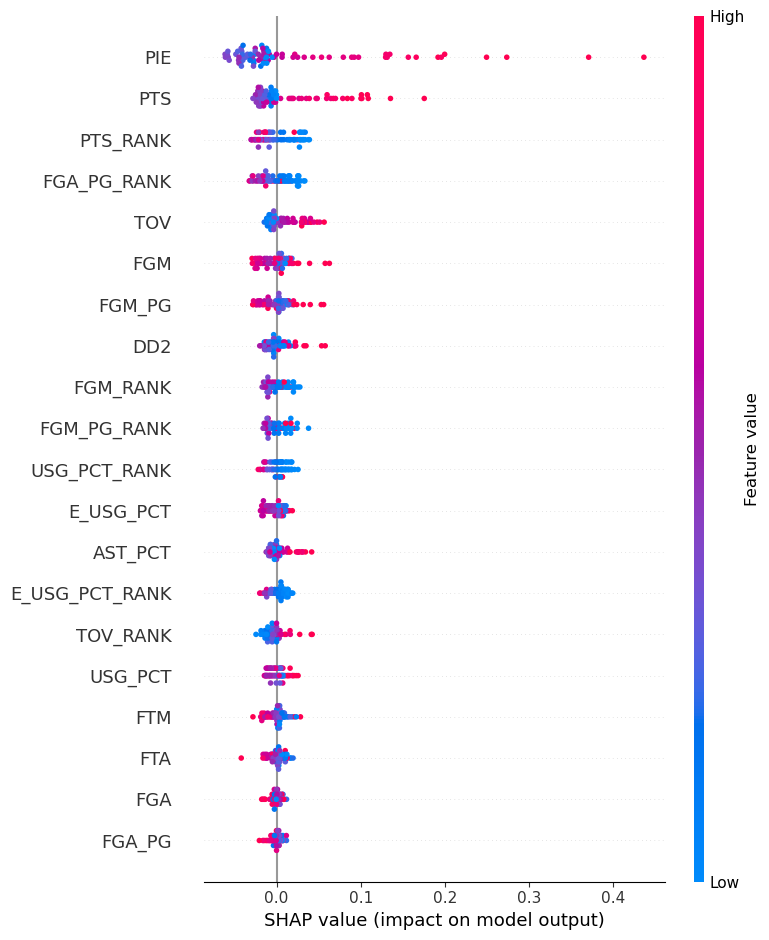

Using 566 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 78/78 [2:00:16<00:00, 92.52s/it] 
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


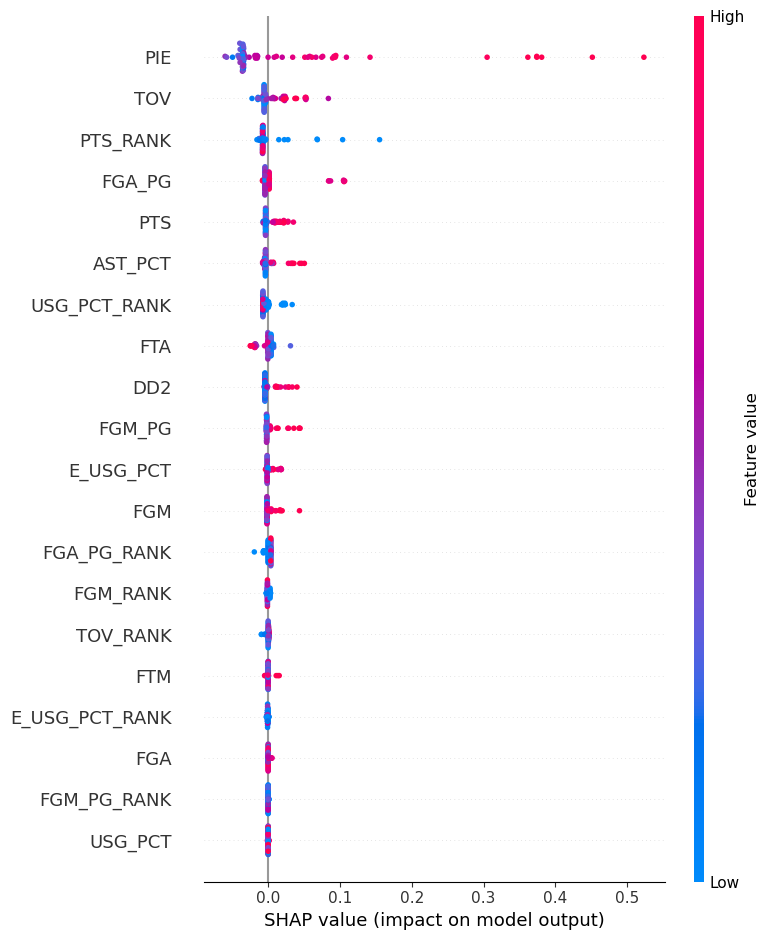

Using 566 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 78/78 [21:06:52<00:00, 974.52s/it]    
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


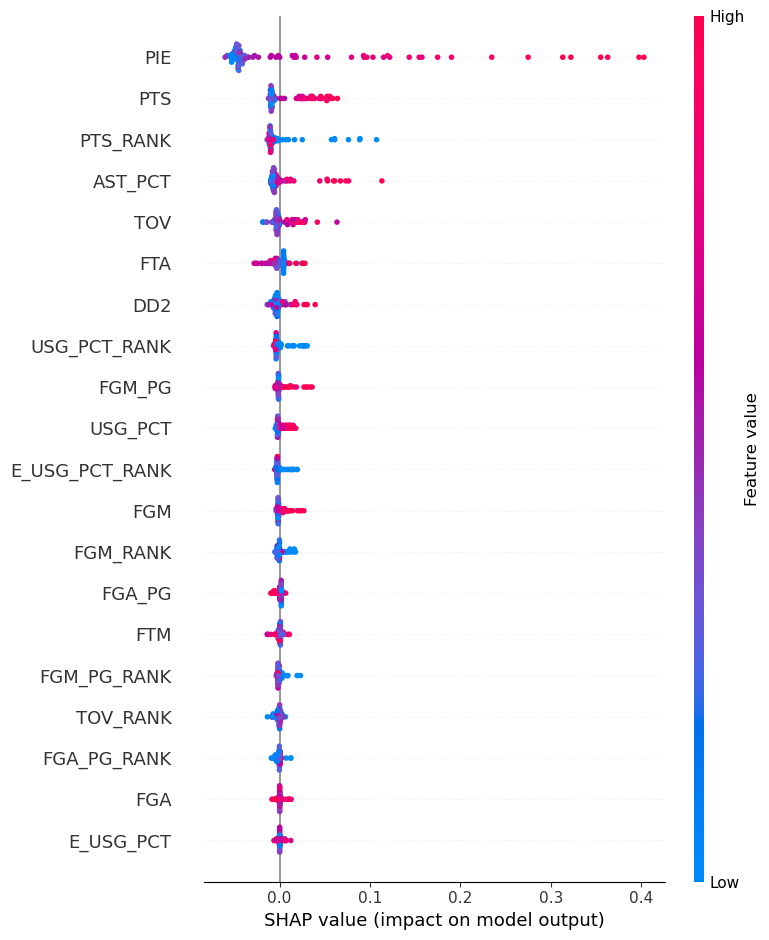

18/18 [==============================] - 0s 655us/step


Using 566 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/78 [00:00<?, ?it/s]

36932/36932 [==============================] - 13s 352us/step


  1%|▏         | 1/78 [00:25<32:44, 25.52s/it]

36932/36932 [==============================] - 13s 355us/step


  3%|▎         | 2/78 [00:47<29:23, 23.21s/it]

36932/36932 [==============================] - 13s 353us/step


  4%|▍         | 3/78 [01:08<28:07, 22.50s/it]

36932/36932 [==============================] - 13s 360us/step


  5%|▌         | 4/78 [01:30<27:21, 22.19s/it]

36932/36932 [==============================] - 13s 353us/step


  6%|▋         | 5/78 [01:52<26:44, 21.99s/it]

36932/36932 [==============================] - 13s 358us/step


  8%|▊         | 6/78 [02:13<26:18, 21.92s/it]

36932/36932 [==============================] - 13s 353us/step


  9%|▉         | 7/78 [02:35<25:46, 21.77s/it]

36932/36932 [==============================] - 13s 346us/step


 10%|█         | 8/78 [02:56<25:19, 21.71s/it]

36932/36932 [==============================] - 13s 353us/step


 12%|█▏        | 9/78 [03:18<24:55, 21.67s/it]

36932/36932 [==============================] - 13s 354us/step


 13%|█▎        | 10/78 [03:40<24:36, 21.71s/it]

36932/36932 [==============================] - 13s 355us/step


 14%|█▍        | 11/78 [04:01<24:12, 21.68s/it]

36932/36932 [==============================] - 13s 351us/step


 15%|█▌        | 12/78 [04:23<23:46, 21.62s/it]

36932/36932 [==============================] - 13s 358us/step


 17%|█▋        | 13/78 [04:45<23:26, 21.63s/it]

36932/36932 [==============================] - 13s 355us/step


 18%|█▊        | 14/78 [05:06<23:04, 21.64s/it]

36932/36932 [==============================] - 13s 360us/step


 19%|█▉        | 15/78 [05:28<22:47, 21.70s/it]

36932/36932 [==============================] - 13s 351us/step


 21%|██        | 16/78 [05:50<22:20, 21.62s/it]

36932/36932 [==============================] - 13s 362us/step


 22%|██▏       | 17/78 [06:11<22:03, 21.70s/it]

36932/36932 [==============================] - 13s 352us/step


 23%|██▎       | 18/78 [06:33<21:38, 21.64s/it]

36932/36932 [==============================] - 13s 353us/step


 24%|██▍       | 19/78 [06:55<21:17, 21.66s/it]

36932/36932 [==============================] - 13s 356us/step


 26%|██▌       | 20/78 [07:16<20:57, 21.67s/it]

36932/36932 [==============================] - 13s 354us/step


 27%|██▋       | 21/78 [07:38<20:33, 21.65s/it]

36932/36932 [==============================] - 13s 358us/step


 28%|██▊       | 22/78 [08:00<20:13, 21.68s/it]

36932/36932 [==============================] - 13s 357us/step


 29%|██▉       | 23/78 [08:21<19:54, 21.72s/it]

36932/36932 [==============================] - 13s 362us/step


 31%|███       | 24/78 [08:43<19:34, 21.75s/it]

36932/36932 [==============================] - 13s 354us/step


 32%|███▏      | 25/78 [09:05<19:11, 21.72s/it]

36932/36932 [==============================] - 13s 359us/step


 33%|███▎      | 26/78 [09:27<18:50, 21.74s/it]

36932/36932 [==============================] - 13s 355us/step


 35%|███▍      | 27/78 [09:48<18:26, 21.70s/it]

36932/36932 [==============================] - 13s 352us/step


 36%|███▌      | 28/78 [10:10<18:07, 21.75s/it]

36932/36932 [==============================] - 13s 352us/step


 37%|███▋      | 29/78 [10:32<17:40, 21.64s/it]

36932/36932 [==============================] - 13s 353us/step


 38%|███▊      | 30/78 [10:53<17:19, 21.66s/it]

36932/36932 [==============================] - 13s 354us/step


 40%|███▉      | 31/78 [11:15<16:58, 21.68s/it]

36932/36932 [==============================] - 13s 356us/step


 41%|████      | 32/78 [11:37<16:36, 21.67s/it]

36932/36932 [==============================] - 13s 360us/step


 42%|████▏     | 33/78 [11:58<16:17, 21.72s/it]

36932/36932 [==============================] - 13s 356us/step


 44%|████▎     | 34/78 [12:20<15:54, 21.69s/it]

36932/36932 [==============================] - 13s 357us/step


 45%|████▍     | 35/78 [12:42<15:32, 21.69s/it]

36932/36932 [==============================] - 13s 352us/step


 46%|████▌     | 36/78 [13:03<15:07, 21.62s/it]

36932/36932 [==============================] - 13s 360us/step


 47%|████▋     | 37/78 [13:25<14:49, 21.70s/it]

36932/36932 [==============================] - 13s 355us/step


 49%|████▊     | 38/78 [13:47<14:26, 21.67s/it]

36932/36932 [==============================] - 13s 355us/step


 50%|█████     | 39/78 [14:09<14:09, 21.77s/it]

36932/36932 [==============================] - 13s 354us/step


 51%|█████▏    | 40/78 [14:30<13:45, 21.73s/it]

36932/36932 [==============================] - 13s 352us/step


 53%|█████▎    | 41/78 [14:52<13:24, 21.74s/it]

36932/36932 [==============================] - 13s 353us/step


 54%|█████▍    | 42/78 [15:14<13:00, 21.69s/it]

36932/36932 [==============================] - 13s 355us/step


 55%|█████▌    | 43/78 [15:35<12:37, 21.66s/it]

36932/36932 [==============================] - 13s 358us/step


 56%|█████▋    | 44/78 [15:57<12:16, 21.67s/it]

36932/36932 [==============================] - 13s 353us/step


 58%|█████▊    | 45/78 [16:19<11:54, 21.66s/it]

36932/36932 [==============================] - 13s 359us/step


 59%|█████▉    | 46/78 [16:40<11:34, 21.71s/it]

36932/36932 [==============================] - 13s 354us/step


 60%|██████    | 47/78 [17:02<11:12, 21.68s/it]

36932/36932 [==============================] - 13s 353us/step


 62%|██████▏   | 48/78 [17:24<10:53, 21.78s/it]

36932/36932 [==============================] - 13s 353us/step


 63%|██████▎   | 49/78 [17:46<10:29, 21.71s/it]

36932/36932 [==============================] - 13s 352us/step


 64%|██████▍   | 50/78 [18:07<10:08, 21.73s/it]

36932/36932 [==============================] - 13s 351us/step


 65%|██████▌   | 51/78 [18:29<09:47, 21.75s/it]

36932/36932 [==============================] - 13s 357us/step


 67%|██████▋   | 52/78 [18:51<09:26, 21.80s/it]

36932/36932 [==============================] - 969s 26ms/step


 68%|██████▊   | 53/78 [1:09:48<6:28:24, 932.20s/it]

36932/36932 [==============================] - 2802s 76ms/step


 69%|██████▉   | 54/78 [2:14:22<12:05:56, 1814.87s/it]

36932/36932 [==============================] - 2872s 53ms/step


 71%|███████   | 55/78 [3:36:58<17:36:53, 2757.11s/it]

36932/36932 [==============================] - 2849s 77ms/step


 72%|███████▏  | 56/78 [4:40:54<18:49:36, 3080.73s/it]

36932/36932 [==============================] - 2952s 80ms/step


 73%|███████▎  | 57/78 [6:04:03<21:18:42, 3653.45s/it]

36932/36932 [==============================] - 3103s 84ms/step


 74%|███████▍  | 58/78 [7:13:19<21:07:59, 3803.97s/it]

36932/36932 [==============================] - 2017s 55ms/step


 76%|███████▌  | 59/78 [8:34:01<21:43:12, 4115.38s/it]

36932/36932 [==============================] - 2829s 77ms/step


 77%|███████▋  | 60/78 [9:21:19<18:39:42, 3732.35s/it]

36932/36932 [==============================] - 13s 363us/step


 78%|███████▊  | 61/78 [9:21:41<12:22:07, 2619.27s/it]

36932/36932 [==============================] - 2377s 64ms/step


 79%|███████▉  | 62/78 [10:01:27<11:19:49, 2549.37s/it]

36932/36932 [==============================] - 2062s 56ms/step


 81%|████████  | 63/78 [10:35:59<10:01:29, 2405.94s/it]

36932/36932 [==============================] - 787s 21ms/step


 82%|████████▏ | 64/78 [10:50:20<7:33:13, 1942.42s/it] 

36932/36932 [==============================] - 1420s 38ms/step


 83%|████████▎ | 65/78 [11:30:36<7:31:40, 2084.67s/it]

36932/36932 [==============================] - 1948s 53ms/step


 85%|████████▍ | 66/78 [12:37:26<8:52:26, 2662.18s/it]

36932/36932 [==============================] - 1177s 32ms/step


 86%|████████▌ | 67/78 [13:29:25<8:33:11, 2799.26s/it]

36932/36932 [==============================] - 1059s 29ms/step


 87%|████████▋ | 68/78 [13:58:26<6:53:37, 2481.73s/it]

36932/36932 [==============================] - 2010s 54ms/step


 88%|████████▊ | 69/78 [14:43:16<6:21:37, 2544.20s/it]

36932/36932 [==============================] - 2115s 57ms/step


 90%|████████▉ | 70/78 [15:31:39<5:53:36, 2652.03s/it]

36932/36932 [==============================] - 2179s 59ms/step


 91%|█████████ | 71/78 [16:25:54<5:30:29, 2832.83s/it]

36932/36932 [==============================] - 1926s 52ms/step


 92%|█████████▏| 72/78 [17:29:50<5:13:21, 3133.62s/it]

36932/36932 [==============================] - 1442s 39ms/step


 94%|█████████▎| 73/78 [18:28:25<4:30:41, 3248.29s/it]

36932/36932 [==============================] - 2039s 55ms/step


 95%|█████████▍| 74/78 [19:17:51<3:30:53, 3163.43s/it]

36932/36932 [==============================] - 1941s 53ms/step


 96%|█████████▌| 75/78 [20:24:10<2:50:24, 3408.23s/it]

36932/36932 [==============================] - 3023s 53ms/step


 97%|█████████▋| 76/78 [21:30:22<1:59:14, 3577.31s/it]

36932/36932 [==============================] - 1548s 42ms/step


 99%|█████████▊| 77/78 [22:13:58<54:49, 3289.02s/it]  

36932/36932 [==============================] - 1092s 30ms/step


100%|██████████| 78/78 [22:32:22<00:00, 1040.28s/it]


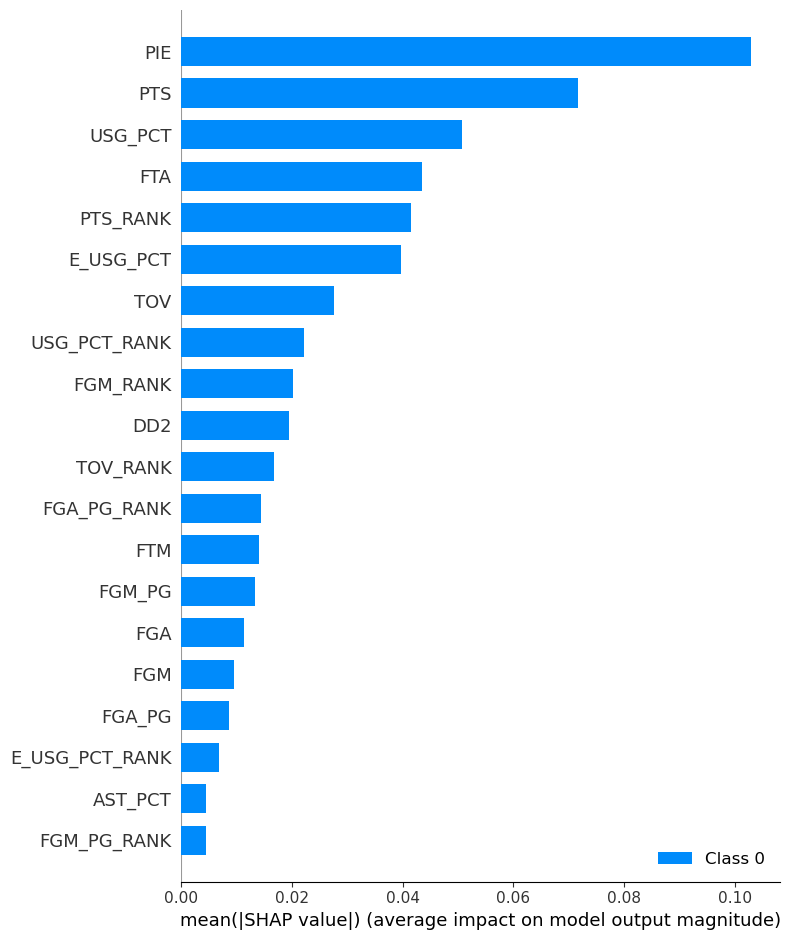

In [177]:
# variable importance
# svr
explainer = shap.KernelExplainer(model_svr.predict, nba_2000_18_new)
shap_rf = explainer.shap_values(nba_2019_22_new)
df = pd.DataFrame(nba_2019_22_new, columns=['FGM', 'FGA', 'FTM', 'FTA', 'TOV', 'PTS', 'DD2', 'FGM_RANK', 'TOV_RANK',
       'PTS_RANK', 'AST_PCT', 'USG_PCT', 'E_USG_PCT', 'PIE', 'FGM_PG',
       'FGA_PG', 'USG_PCT_RANK', 'E_USG_PCT_RANK', 'FGM_PG_RANK',
       'FGA_PG_RANK'])
feature_names = list(df.columns)
shap.summary_plot(shap_rf, df, feature_names=feature_names)
# gradient boosting
explainer = shap.KernelExplainer(model_gb.predict, nba_2000_18_new)
shap_gb = explainer.shap_values(nba_2019_22_new)
df = pd.DataFrame(nba_2019_22_new, columns=['FGM', 'FGA', 'FTM', 'FTA', 'TOV', 'PTS', 'DD2', 'FGM_RANK', 'TOV_RANK',
       'PTS_RANK', 'AST_PCT', 'USG_PCT', 'E_USG_PCT', 'PIE', 'FGM_PG',
       'FGA_PG', 'USG_PCT_RANK', 'E_USG_PCT_RANK', 'FGM_PG_RANK',
       'FGA_PG_RANK'])
feature_names = list(df.columns)
shap.summary_plot(shap_gb, df, feature_names=feature_names)

# random forest
explainer = shap.KernelExplainer(model_rf.predict, nba_2000_18_new)
shap_rf = explainer.shap_values(nba_2019_22_new)
df = pd.DataFrame(nba_2019_22_new, columns=['FGM', 'FGA', 'FTM', 'FTA', 'TOV', 'PTS', 'DD2', 'FGM_RANK', 'TOV_RANK',
       'PTS_RANK', 'AST_PCT', 'USG_PCT', 'E_USG_PCT', 'PIE', 'FGM_PG',
       'FGA_PG', 'USG_PCT_RANK', 'E_USG_PCT_RANK', 'FGM_PG_RANK',
       'FGA_PG_RANK'])
feature_names = list(df.columns)
shap.summary_plot(shap_rf, df, feature_names=feature_names)

# neural network
explainer = shap.KernelExplainer(model_nn.predict, nba_2000_18_new)
shap_nn = explainer.shap_values(nba_2019_22_new)
df = pd.DataFrame(nba_2019_22_new, columns=['FGM', 'FGA', 'FTM', 'FTA', 'TOV', 'PTS', 'DD2', 'FGM_RANK', 'TOV_RANK',
       'PTS_RANK', 'AST_PCT', 'USG_PCT', 'E_USG_PCT', 'PIE', 'FGM_PG',
       'FGA_PG', 'USG_PCT_RANK', 'E_USG_PCT_RANK', 'FGM_PG_RANK',
       'FGA_PG_RANK'])
feature_names = list(df.columns)
shap.summary_plot(shap_nn, df, feature_names=feature_names)

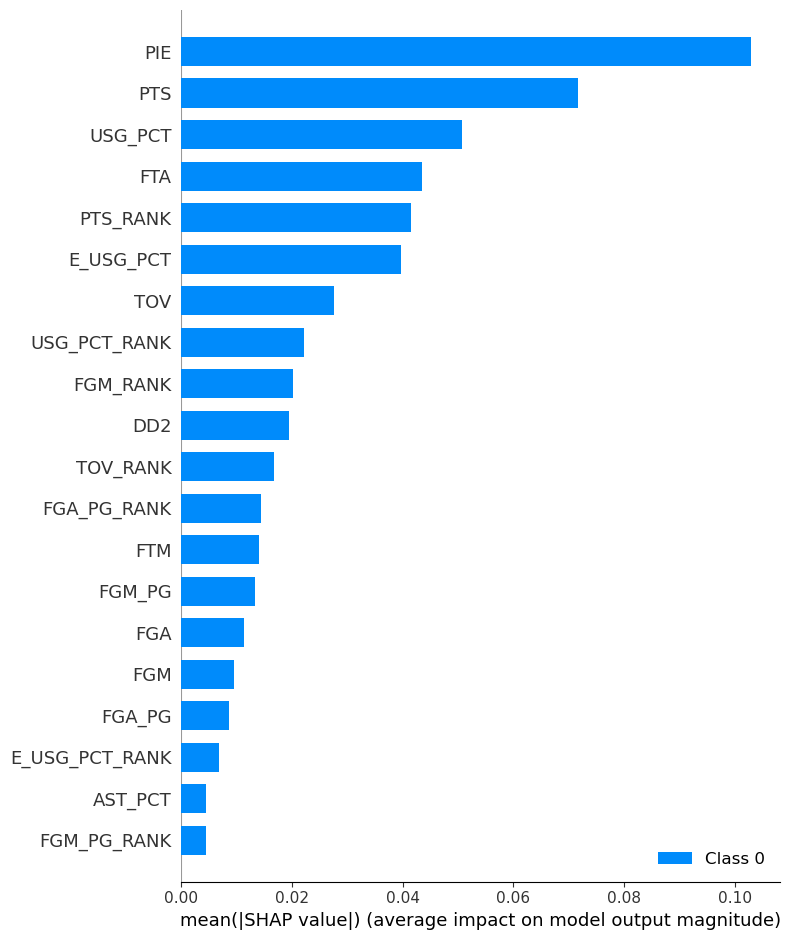